## Requirements env + moduls

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone
!cd yolov5
!pip install -r requirements.txt  # install
!pip install ultralytics
!pip install clearml
!pip install pillow==11.0.0 
!pip install requests==2.32.3 
!pip install setuptools==75.6.0 
!pip install tqdm==4.67.1
!pip install -U ipywidgets

Cloning into 'yolov5'...
remote: Enumerating objects: 17129, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 17129 (delta 32), reused 10 (delta 10), pack-reused 17080 (from 4)
Receiving objects: 100% (17129/17129), 15.84 MiB | 29.32 MiB/s, done.
Resolving deltas: 100% (11744/11744), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.9/906.9 kB 15.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 38.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the so

In [2]:

import torch
from IPython import display
from IPython.display import clear_output
from pathlib import Path
import yaml
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import io
import os
import cv2
import json
import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm
%matplotlib inline

In [3]:
IMAGES_PATH = "/kaggle/input/birdies/images"
LABELS_PATH = "/kaggle/input/birdies/labels"

labels = os.listdir(LABELS_PATH)

# Split data
train, test = train_test_split(labels, test_size=0.2, shuffle=True)
valid, test = train_test_split(test, test_size=0.2)

print(f"train: {len(train)}; test: {len(test)}; valid: {len(valid)}") #valid: {len(valid)}

train: 1608; test: 81; valid: 321


In [4]:
def move_files_to_dir(files, dirname):
    for label_filename in tqdm(files, total = len(files)):
        image_filename = f"{label_filename[:-4]}.jpg"
        shutil.copy(f"{IMAGES_PATH}/{image_filename}", f"{dirname}/images/{image_filename}")
        shutil.copy(f"{LABELS_PATH}/{label_filename}", f"{dirname}/labels/{label_filename}")


# Make folders
if not os.path.exists("test/images"):
    os.makedirs("test/images")
if not os.path.exists("test/labels"):
    os.makedirs("test/labels")
if not os.path.exists("train/images"):
    os.makedirs("train/images")
if not os.path.exists("train/labels"):
    os.makedirs("train/labels")
if not os.path.exists("valid/images"):
    os.makedirs("valid/images")
if not os.path.exists("valid/labels"):
    os.makedirs("valid/labels")

# Move splits to folders
move_files_to_dir(train, "train")
move_files_to_dir(test, "test")
move_files_to_dir(valid, "valid")

# Path
train_path = "../train/images"
test_path = "../test/images"
valid_path = "../valid/images"

100%|██████████| 321/321 [00:03<00:00, 88.39it/s] 


## Make Yaml

In [5]:
with open("data.yaml", "w") as file:
    yaml.dump({
        "train": train_path,
        "test": test_path,
        "val": valid_path,
        "names": ['birds'],
        "nc": 1,
        #"names": [f'{name}' for name in names]
    } , stream=file, default_flow_style=None)

print("Now we are ready to train yolov5 model")
! ls 

Now we are ready to train yolov5 model
data.yaml  test  train	valid  yolov5


## Train

In [6]:
PROJECT_NAME = "birds"
BASE_MODEL = "yolov5m6.pt"
BATCH = 64
TRAIN_EPOCHS = 40
#VAL_BATCH = 64

In [7]:
! python yolov5/train.py --batch $BATCH --img 600 --epochs $TRAIN_EPOCHS --data "data.yaml" --weights $BASE_MODEL --project $PROJECT_NAME --name 'feature_extraction' --cache --freeze 12

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-01-13 15:34:40.586158: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-13 15:34:40.586262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-13 15:34:40.713792: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to regi

In [8]:
WEIGHTS_BEST = f"{PROJECT_NAME}/feature_extraction/weights/best.pt"
! python yolov5/val.py --weights $WEIGHTS_BEST --batch $BATCH --data 'data.yaml' --task test --project $PROJECT_NAME --name 'validation_on_test_data' --augment

val: data=data.yaml, weights=['birds/feature_extraction/weights/best.pt'], batch_size=64, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=True, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=birds, name=validation_on_test_data, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-395-g6420a1db Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 276 layers, 35248920 parameters, 0 gradients, 48.9 GFLOPs
test: Scanning /kaggle/working/test/labels... 81 images, 0 backgrounds, 0 corrup
test: New cache created: /kaggle/working/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   
                   all         81         81      0.979      0.975      0.975      0.879
Speed: 0.2ms pre-process, 42.9ms inference, 2.6ms NMS per image at shape (64, 3, 640, 640)
Results saved to birds/validation_on_test_data


## Make box on test data

In [9]:
! python yolov5/detect.py --weights $WEIGHTS_BEST --conf 0.6 --source 'test/images' --project $PROJECT_NAME --name 'detect_test' --augment --line=3

detect: weights=['birds/feature_extraction/weights/best.pt'], source=test/images, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.6, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=True, visualize=False, update=False, project=birds, name=detect_test, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-395-g6420a1db Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 276 layers, 35248920 parameters, 0 gradients, 48.9 GFLOPs
image 1/81 /kaggle/working/test/images/0025.jpg: 448x640 1 birds, 215.1ms
image 2/81 /kaggle/working/test/images/0069.jpg: 448x640 1 birds, 61.9ms
image 3/81 /kaggle/working/test/images/0070.jpg: 384x640 1 birds, 146.7ms
image 4/81 /kaggle/working/test/images/0107.jpg: 512x640 1 birds, 195.4ms
image 5/81 /kag

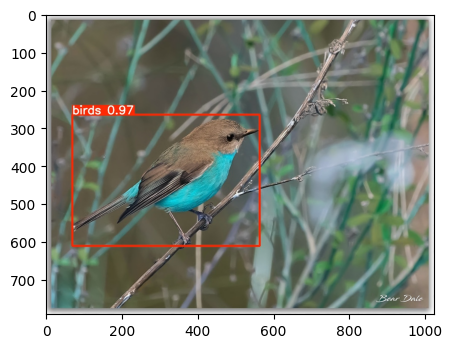

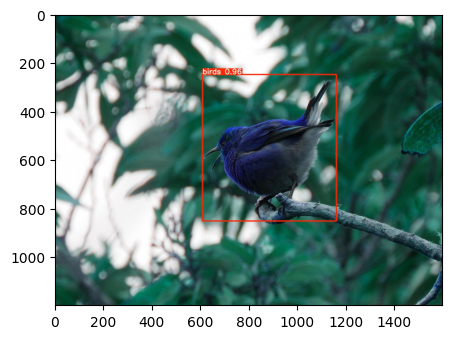

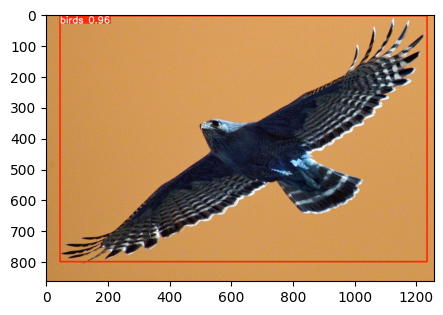

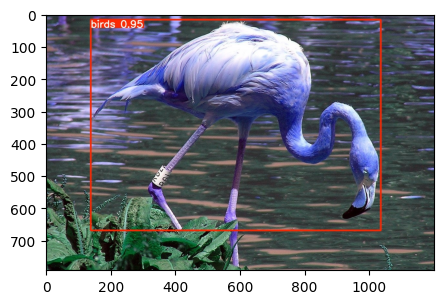

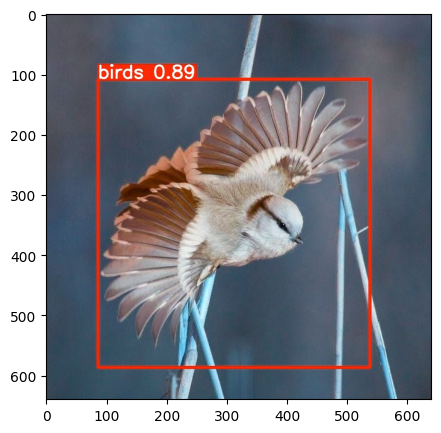

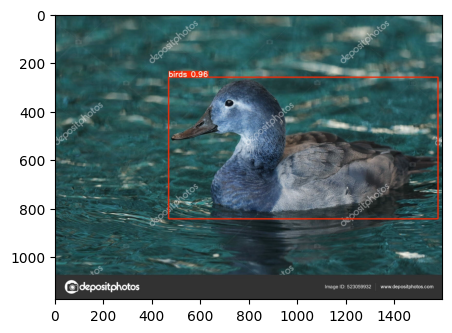

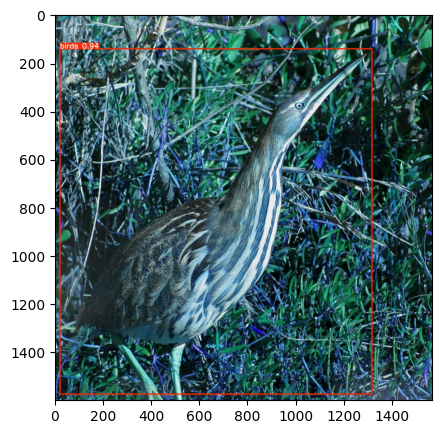

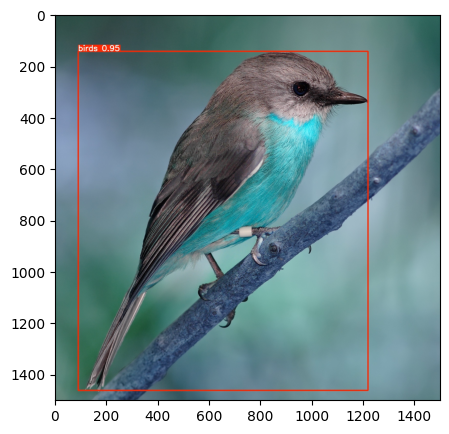

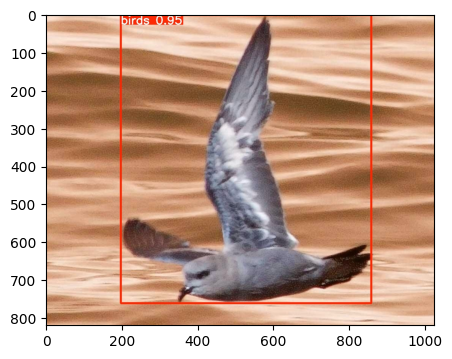

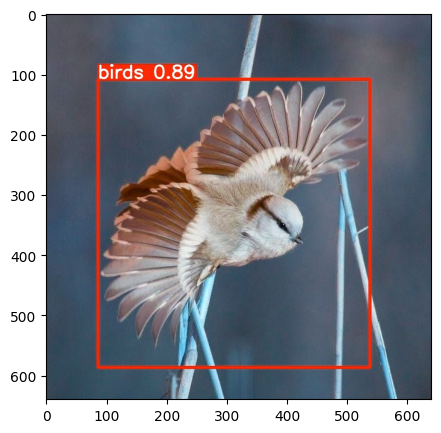

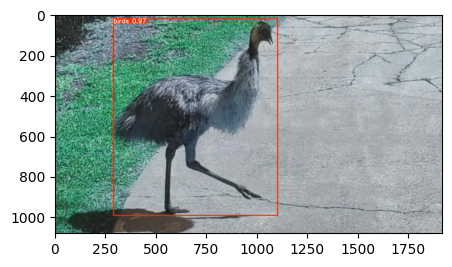

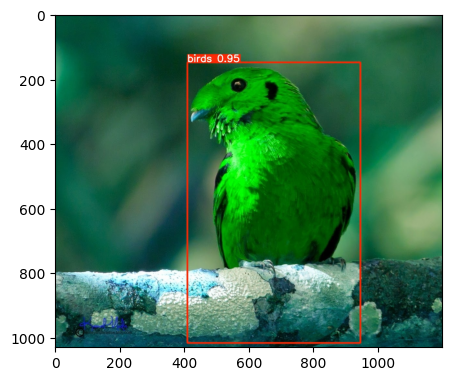

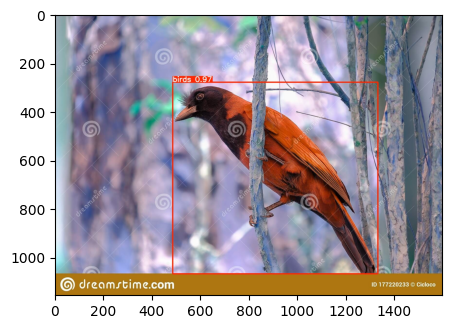

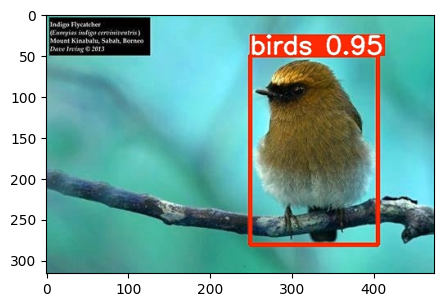

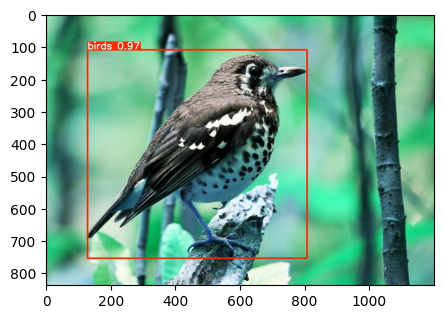

In [31]:
imgs = glob('/kaggle/working/birds/detect_test/*')
choice = np.random.choice(imgs, 15)
for i in choice:
    img = cv2.imread(i)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)